In [1]:
%reset -f
from pythonrc import *

# Simple test

## Setup the environment and the configuration

In [2]:
tunnel.extra_attributes["rate_limit"] = 1.0
voithschneider_port.extra_attributes["rate_limit"] = 1.0
voithschneider_starboard.extra_attributes["rate_limit"] = 1.0


def initialize_allocator(
    allocator_type: skadipy.allocator.AllocatorBase, **kwargs
) -> skadipy.allocator.AllocatorBase:
    return allocator_type(
        actuators=[
            tunnel,
            voithschneider_port,
            voithschneider_starboard,
        ],
        force_torque_components=[
            skadipy.allocator.ForceTorqueComponent.X,
            skadipy.allocator.ForceTorqueComponent.Y,
            skadipy.allocator.ForceTorqueComponent.N,
        ],
        **kwargs,
    )


time_step = 0.1
gamma = [0.1, 0.1, 0.1]
mu = [0.1, 0.1, 0.1]
rho = [0.1, 0.1, 0.1]
zeta = [1.0, 1.0, 1.0]
lambda_p = [0.99, 0.4, 0.0]


def initialize_allocators():
    a = []
    for g, m, r, l, z in zip(gamma, mu, rho, lambda_p, zeta):
        a.append(
            initialize_allocator(
                skadipy.allocator.reference_filters.MinimumMagnitudeAndAzimuth,
                gamma=g,
                mu=m,
                rho=r,
                zeta=z,
                time_step=time_step,
                lambda_=l,
            )
        )
    a.append(
        initialize_allocator(
            skadipy.allocator.reference_filters.MinimumMagnitude,
            gamma=0.1,
            mu=0.1,
            rho=0.1,
            time_step=time_step,
        )
    )
    return a

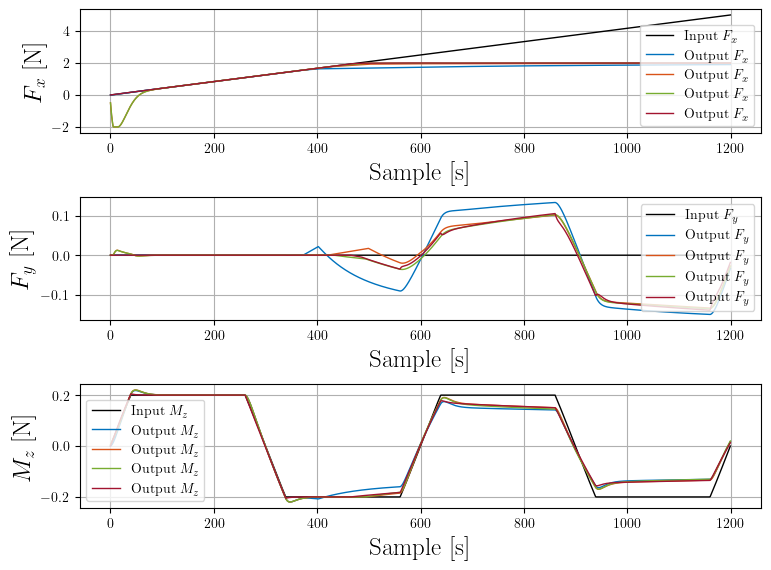

In [3]:
n = 1200
tau_cmd = np.zeros((n, 6))
tau_cmd[:,0] = np.linspace(0, 5, n)
tau_cmd[:,5] = gen_clipped_sin(n, 0.5, 2.0, 0.0, 0, -0.2, 0.2)

xi_hist, theta_hist, tau_hist = run_tests(tau_cmd, allocators=initialize_allocators())
plot_histories(tau_cmd=tau_cmd, tau_alloc=tau_hist)

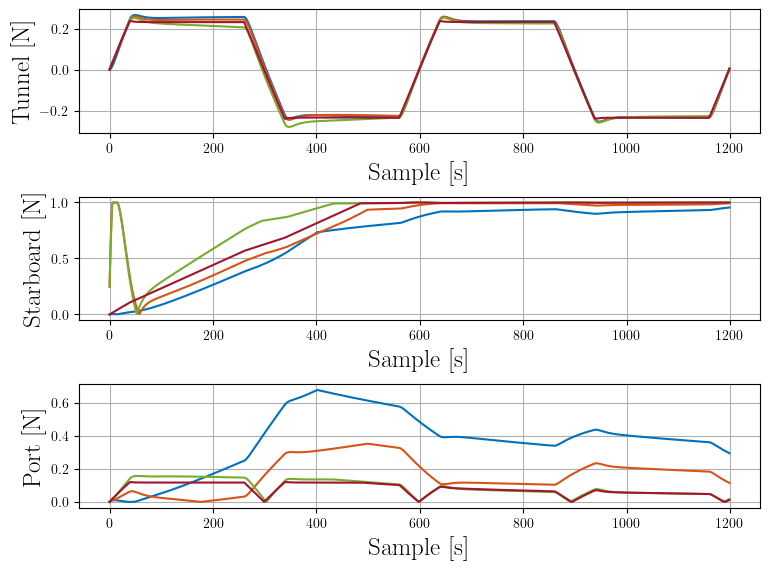

In [4]:
plot_thruster_forces(xi_hist)

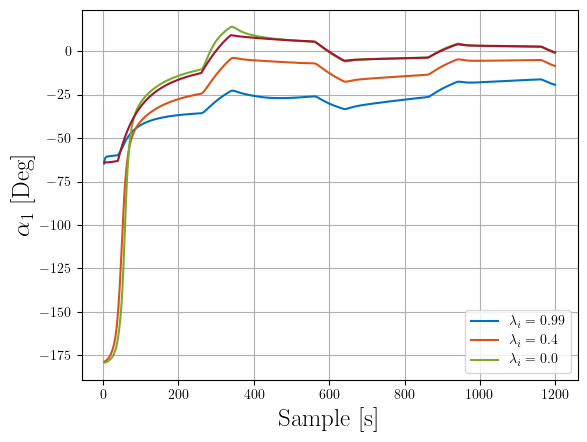

In [5]:
plot_angles(xi_hist)
l = []
for i in lambda_p:
    l.append(f"$\lambda_i = {i}$")
plt.legend(l)
plt.grid(True)

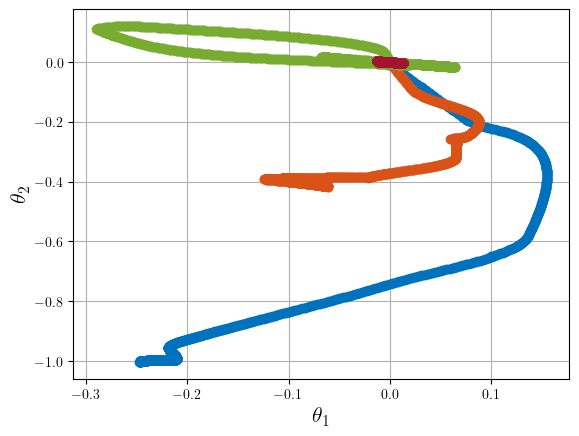

In [6]:
plot_theta_histories(theta_hist)

In [7]:
gamma.append(0.1)
mu.append(0.1)
rho.append(0.1)
lambda_p.append(0.0)

save_mat(
    filename="data/015.mat",
    inputs=tau_cmd,
    xi=xi_hist,
    thetas=theta_hist,
    outputs=tau_hist,
    zeta=zeta,
    rho=rho,
    gamma=gamma,
    mu=mu,
    lambda_p=lambda_p,
    thruster=voithschneider_port
)